In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
name_basics = pd.read_csv("/kaggle/input/imdb-dataset/name.basics.tsv/data.tsv", sep='\t')
title_crew = pd.read_csv("/kaggle/input/d/sawio47/imdb-dataset/title.crew.tsv", sep='\t')
title_basics = pd.read_csv("/kaggle/input/imdb-dataset/title.basics.tsv/data.tsv", sep='\t', low_memory=False)
title_ratings = pd.read_csv("/kaggle/input/imdb-dataset/title.ratings.tsv/data.tsv", sep='\t')

In [2]:
name_basics = pd.read_csv("./name.basics.tsv", sep='\t')
title_crew = pd.read_csv("./title.crew.tsv", sep='\t')
title_basics = pd.read_csv("./title.basics.tsv", sep='\t', low_memory=False)
title_ratings = pd.read_csv("./title.ratings.tsv", sep='\t')

In [3]:
# transform directors, so we can match each one with a movie later one
directors = title_crew
directors.directors = title_crew.directors.apply(lambda x: x.split(','))
directors = directors.drop(columns=['writers'])
directors = directors.explode('directors')
directors.head()

,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690


In [4]:
# cleanup crew DF
crew = name_basics.drop(columns=[ "primaryProfession", "knownForTitles", "deathYear"])
crew.head()

,nconst,primaryName,birthYear
0,nm0000001,Fred Astaire,1899
1,nm0000002,Lauren Bacall,1924
2,nm0000003,Brigitte Bardot,1934
3,nm0000004,John Belushi,1949
4,nm0000005,Ingmar Bergman,1918


In [5]:
# extend directors by actual names
directors = directors.join(name_basics.set_index("nconst"), on="directors")
directors.head()

,tconst,directors,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0000001,nm0005690,William K.L. Dickson,1860,1935,"cinematographer,director,producer","tt0308254,tt1496763,tt0219560,tt1428455"
1,tt0000002,nm0721526,Émile Reynaud,1844,1918,"director,animation_department,producer","tt16763674,tt16763740,tt13125956,tt0000003"
2,tt0000003,nm0721526,Émile Reynaud,1844,1918,"director,animation_department,producer","tt16763674,tt16763740,tt13125956,tt0000003"
3,tt0000004,nm0721526,Émile Reynaud,1844,1918,"director,animation_department,producer","tt16763674,tt16763740,tt13125956,tt0000003"
4,tt0000005,nm0005690,William K.L. Dickson,1860,1935,"cinematographer,director,producer","tt0308254,tt1496763,tt0219560,tt1428455"


In [6]:
directors = directors.loc[directors['birthYear']!= '\\N'].dropna(how="any")

In [7]:
# add movie ratings
director_ratings  = directors.join(title_ratings.set_index("tconst"), on="tconst").join(title_basics.set_index("tconst"), on="tconst")
director_ratings = director_ratings.loc[director_ratings['titleType'].isin(['short', 'movie', 'tvShort', 'tvMovie'])]
director_ratings.drop(
    columns=[
        "titleType",
        "originalTitle",
        "isAdult",
        "endYear",
        "runtimeMinutes",
        "isAdult",
        "genres",
    ],
    inplace=True
)

director_ratings.dropna(how="any", inplace=True)

,averageRating,numVotes
count,264038.000000,2.640380e+05
mean,6.267992,3.916416e+03
std,1.264621,3.795575e+04
min,1.000000,5.000000e+00
25%,5.500000,1.800000e+01
50%,6.300000,5.400000e+01
75%,7.100000,2.780000e+02
max,10.000000,2.725594e+06


In [8]:
director_ratings = director_ratings.loc[
    (director_ratings["startYear"] != "\\N")
    & (director_ratings["birthYear"] != "\\N")
    & (director_ratings["averageRating"] != "\\N")
    & (director_ratings["numVotes"] != "\\N")
]
director_ratings.head()


,tconst,directors,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,averageRating,numVotes,primaryTitle,startYear
8852606,tt7926166,nm8395992,Andrey Gromov,2004,\N,"producer,actor,writer","tt6018006,tt6017238,tt7926166,tt6207700",1.0,28.0,Chains of Mephistopheles 2,2017
3108938,tt1391128,nm3354124,Alexander Freeman,1987,\N,"producer,director,editor","tt15014930,tt7837882,tt4704040",1.0,5.0,The Tell-Tale Heart,2009
6575820,tt2786188,nm5556666,Matthew Berdyck,1976,\N,"director,writer,editor","tt3816676,tt2786188,tt2823486,tt3587840",1.0,118.0,Wayward Traveler: Nevada Train/Semi Crash,2011
388297,tt0405091,nm1241444,Lawson Harris,1897,1948,"director,actor,producer","tt0356508,tt0350717,tt0331663,tt0405091",1.0,18.0,Law or Loyalty,1926
8843520,tt7906266,nm2121515,Ching Shen Chuang,1973,\N,"director,actor,assistant_director","tt22497950,tt9686038,tt23650278,tt8463258",1.0,94.0,The Barber Shop,2013


In [9]:
director_ratings[
    ["startYear", "birthYear", "averageRating", "numVotes"]
] = director_ratings[["startYear", "birthYear", "averageRating", "numVotes"]].apply(
    pd.to_numeric
)

director_ratings['directorAge']= director_ratings['startYear'] - director_ratings['birthYear'] + 1

In [10]:
director_movie_count = pd.DataFrame(
    director_ratings.loc[
        (director_ratings["directorAge"] > 1)
        & (director_ratings["directorAge"] < 100)
        & (director_ratings["numVotes"] > 10000)
    ]
    .groupby("directors")["tconst"]
    
    .nunique()
)


In [11]:
director_movie_count.rename(columns={"tconst": "movieCount"}, inplace=True)
director_movie_count.sort_values(by="movieCount")

,movieCount
directors,
nm9751348,1
nm0425894,1
nm0424466,1
nm1099711,1
nm0424035,1
...,...
nm0000217,27
nm0000229,35
nm0000033,37


In [ ]:
director_ratings = director_ratings.join(director_movie_count, on="directors")
director_ratings = director_ratings.loc[director_ratings['movieCount']>9]


In [18]:
director_ratings['directorAge']= director_ratings['startYear'] - director_ratings['birthYear'] + 1

In [30]:
def linReg(x, y):
    '''linear regression using numpy starting from two one dimensional numpy arrays'''
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return pd.Series({'slope':slope, 'intercept': intercept})
res = director_ratings.groupby('primaryName').apply(lambda x: linReg(x.directorAge, x.averageRating))

res['abs']= abs(res['slope'])
res.sort_values(by="slope")

,slope,intercept,abs
primaryName,,,
David Zucker,-0.119985,11.779252,0.119985
John McTiernan,-0.102732,11.038400,0.102732
Kar-Wai Wong,-0.063405,9.464503,0.063405
Malcolm D. Lee,-0.059601,8.181603,0.059601
Walter Hill,-0.059261,9.263837,0.059261
...,...,...,...
Brett Ratner,0.056393,3.427356,0.056393
Curtis Hanson,0.057542,3.433290,0.057542
John Ford,0.060226,3.275266,0.060226


In [29]:
from numpy import mean


res.slope.median()

-0.0006003098188352731

<Axes: xlabel='directorAge', ylabel='averageRating'>

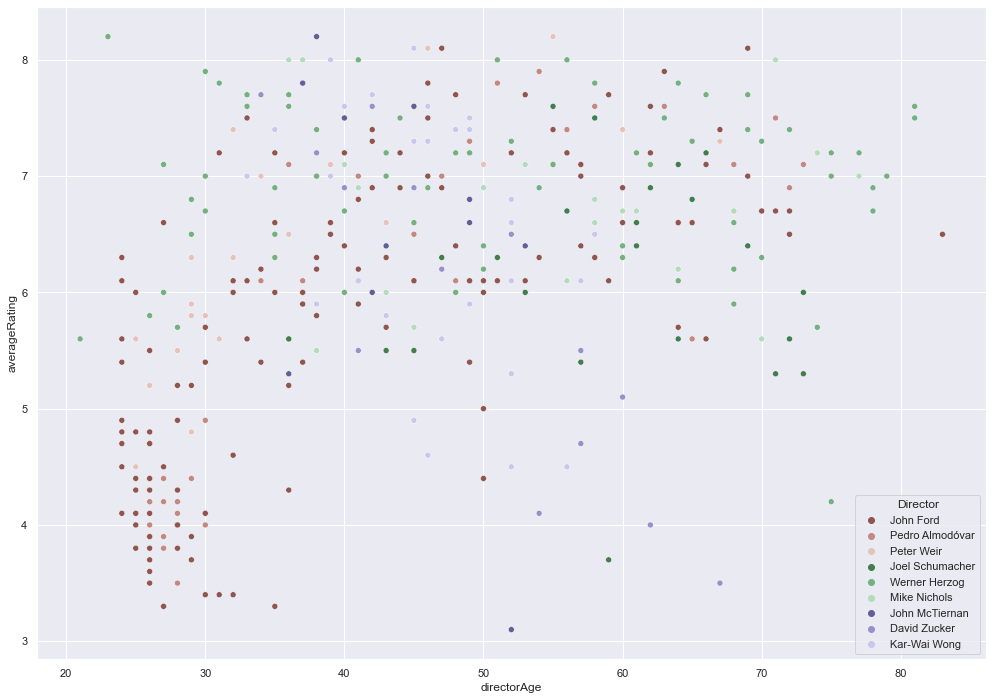

In [113]:
import seaborn as sns

sns.set_theme(style="whitegrid")

director_ratings.rename(columns={'primaryName': 'Director'}, inplace=True)

import matplotlib.pyplot as plt
plt.style.use("dark_background")

sns.set(rc={"figure.figsize": (17, 12)})

top_3 = [
    "John Ford",
    "Peter Weir",
    "Pedro Almodóvar",
]

bottom_3 = [
    "David Zucker",
    "John McTiernan",
    "Kar-Wai Wong",
]

stable_3 = [
    "Werner Herzog",
    "Mike Nichols",
    "Joel Schumacher",
]


sns.scatterplot(
    data=director_ratings.loc[director_ratings["Director"].isin(top_3)],
    x="directorAge",
    y="averageRating",
    hue="Director", 
    palette="ch:start=1,rot=-.0,d=.8,l=.4",
)
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(
    data=director_ratings.loc[director_ratings["Director"].isin(stable_3)],
    x="directorAge",
    y="averageRating",
    hue="Director",
    
    palette="ch:start=2,rot=-.0,d=.8,l=.4",
)

sns.scatterplot(
    data=director_ratings.loc[director_ratings["Director"].isin(bottom_3)],
    x="directorAge",
    y="averageRating",
    hue="Director",
    
    palette="ch:start=3,rot=-.0,d=.8,l=.4",
)


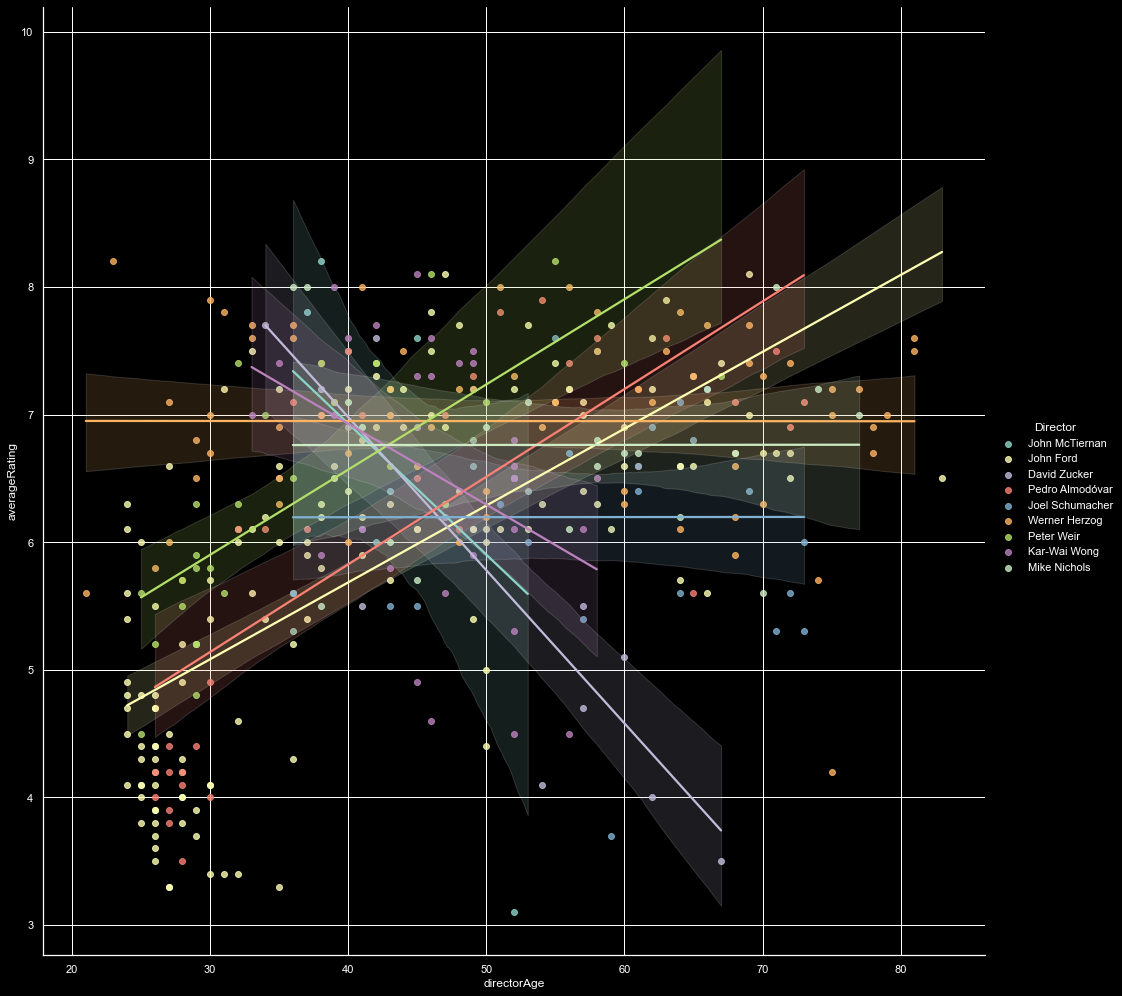

In [114]:
# sns.lmplot(data=director_ratings, x="directorAge", y="averageRating", hue="primaryName", aspect=17/7 ,height=7, legend=False )
plt.style.use("dark_background")

sns.lmplot(
    data=director_ratings.loc[director_ratings["Director"].isin(top_3 + stable_3+ bottom_3)],
    x="directorAge",
    y="averageRating",
    hue="Director",
    height=14
)

